In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

In [5]:
df = pd.read_csv('cs-training.csv', index_col='Unnamed: 0')
df.head(2)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0


In [6]:
df.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [7]:
df.SeriousDlqin2yrs.value_counts()

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64

In [8]:
df.SeriousDlqin2yrs.value_counts(normalize=True) * 100

0    93.316
1     6.684
Name: SeriousDlqin2yrs, dtype: float64

In [52]:
93/ 7

13.285714285714286

In [53]:
7 * 13

91

In [9]:
df.isnull().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [12]:
df.isnull().mean() * 100

SeriousDlqin2yrs                         0.000000
RevolvingUtilizationOfUnsecuredLines     0.000000
age                                      0.000000
NumberOfTime30-59DaysPastDueNotWorse     0.000000
DebtRatio                                0.000000
MonthlyIncome                           19.820667
NumberOfOpenCreditLinesAndLoans          0.000000
NumberOfTimes90DaysLate                  0.000000
NumberRealEstateLoansOrLines             0.000000
NumberOfTime60-89DaysPastDueNotWorse     0.000000
NumberOfDependents                       2.616000
dtype: float64

model score: 60.480142473185914


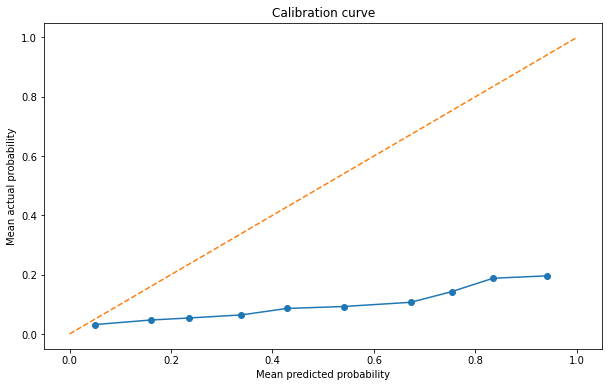

In [56]:
numeric_features = ['MonthlyIncome', 'NumberOfDependents']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())])

# categorical_features = ['embarked', 'sex', 'pclass']
# categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
#         ('cat', categorical_transformer, categorical_features)
    ])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(n_estimators=200, 
                                                            max_depth=5, 
                                                            min_samples_split=100,
                                                            min_samples_leaf=100, 
                                                            n_jobs=8))])

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='SeriousDlqin2yrs'), df['SeriousDlqin2yrs'], test_size=0.2,
                                                    random_state=0)

clf.fit(X_train, y_train)
auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]) * 100


print(f"model score: {auc}")

y_predicted = clf.predict_proba(X_test)[:, 1]
prob_true, prob_predicted = calibration_curve(y_true=y_test, y_prob=y_predicted, n_bins=10, normalize=True)
plt.figure(figsize=(10, 6))
plt.plot(prob_predicted, prob_true, '-o')
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('Mean predicted probability')
plt.ylabel('Mean actual probability')
plt.title('Calibration curve')
plt.show()